In [1]:
import sklearn
import PIL
from matplotlib import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import transform, color
from PIL import Image 
import numpy as np
from os import listdir
from os.path import isfile, join
import os

## Data Exploration

### General properties of data

* all pictures in png-format 
* no consistent size and image ratio
* 13779 images parsitized, 13779 images uninfected, total 27558 images  
* all images are in color
* high amount of features, thus feature engineering is indicated

### Load data

images parasitized

In [2]:
sample_images_positive = []
i=0
for filename in listdir('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/'):
    if i < 10:
        img = plt.imread('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/' + filename)
        sample_images_positive.append(img)
        i+=1

images uninfected

In [3]:
sample_images_negative = []
i=0
for filename in listdir('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/'):
    if i < 10:
        img = plt.imread('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/' + filename)
        sample_images_negative.append(img)
        i+=1

### Qualitative analysis and visualization

<Figure size 432x288 with 0 Axes>

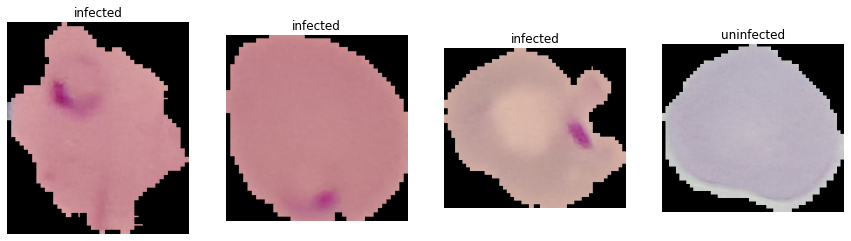

In [4]:
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(15,15))
ax1 = axes[0]
ax1.imshow(sample_images_positive[0], cmap='Greys_r')
ax1.set_title('infected')
ax1.axis('off')
ax2 = axes[1]
ax2.imshow(sample_images_positive[5], cmap='Greys_r')
ax2.set_title('infected')
ax2.axis('off')
ax3 = axes[2]
ax3.imshow(sample_images_positive[9], cmap='Greys_r')
ax3.set_title('infected')
ax3.axis('off')
ax4 = axes[3]
ax4.imshow(sample_images_negative[0], cmap='Greys_r')
ax4.set_title('uninfected')
ax4.axis('off');

summary:   
* images with infections show darker stains of differing color. These can have very differnt forms, sizes and shades. The morphology of the stains seems of secondary relevance
* the highest contrast within the images shows on the border between the samples and the black background. This might pose a disadvantage for the algorithm

## Data representation

### Grayscale

It is indicated to change the color scheme to grayscale due to the following reasons
* as the color agent might take on a differing color in different data samples, the generalization is increased by changing the color scheme to grayscale
* it is easier to handle a dataset with only one color channel
* the calculation effort is reduced

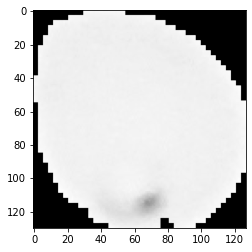

In [5]:
image_grayscale = color.rgb2gray(sample_images_positive[5])
plt.imshow(image_grayscale, cmap='Greys_r')

* The stains of the infected cells are also well discernible on a grayscale dark-light continuum   
* The black background again shows as a disadvantage as the highest contrast is given between the black background and teh sample area.

### Set the background to a bright shade

This measure of preprocessing is taken due to the following reasons:
* the stains of the infected cells are then the darkest areas in the image and this might make it easier for the algorithm to discern infected from uninfected samples
* the border between the sample and the background is no longer the dominating pattern in the images



padding function to keep the resolution of the pictures

In [6]:
def padding(image, size):
    desired_size = size
    old_size = image.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = image.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new('RGB',(desired_size, desired_size))
    new_im.paste(image, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    return new_im

function for brightening the image background

In [7]:
def brighten(image):
    max_ = np.max(image)
    image[image==0.0] = max_
    return image

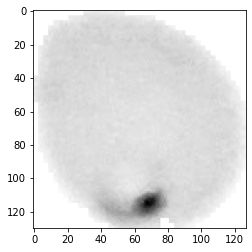

In [8]:
img = sample_images_positive[5]
img = np.array(img)
img = color.rgb2gray(img)
img = brighten(img)
plt.imshow(img, cmap='Greys_r');

In [9]:
X_positive_bright = []
for filename in listdir('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/'):
    if 'Thumbs.db' not in filename:
        img = Image.open('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/' + filename)
        img = padding(img, 220)
        img = np.array(img)
        img = color.rgb2gray(img)
        img = brighten(img.reshape(220*220))
        img = transform.resize(img.reshape(220,220), (100,100))
        X_positive_bright.append(img)
X_positive_bright = np.array(X_positive_bright)

In [10]:
X_negative_bright = []
for filename in listdir('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/'):
    if 'Thumbs.db' not in filename:
        img = Image.open('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/' + filename)
        img = padding(img, 220)
        img = np.array(img)
        img = color.rgb2gray(img)
        img = brighten(img.reshape(220*220))
        img = transform.resize(img.reshape(220,220), (100,100))
        X_negative_bright.append(img)
X_negative_bright = np.array(X_negative_bright)

### Flatten

In [11]:
X_positive_bright = X_positive_bright.reshape(13779, 100*100)
X_negative_bright = X_negative_bright.reshape(13779, 100*100)

### Normalization

In [12]:
X_positive_bright.min(), X_positive_bright.max(), X_negative_bright.min(), X_negative_bright.max()

(0.0806995401124341,
 0.9148203921568625,
 0.05867339546138877,
 0.9469815686274505)

### Feature Engineering: Principal Component Analysis

For feature engineering principal component analysis should be adopted due to the following reasons:
* the number of features can be reduced by this measure
* components are identified that explain a high amount of variance. Through this the training of the model is simplified  
* for the support vector machine as the model class of choice the principal component analysis is indicated in any case

In [13]:
from sklearn.decomposition import PCA
X_full = np.row_stack((X_positive_bright, X_negative_bright))
pca_full_variance = PCA(n_components = 0.95) 
pca_full_variance.fit(X_full) 
pca_full_variance.components_.shape

(96, 10000)

96 components already explain 95% of variance

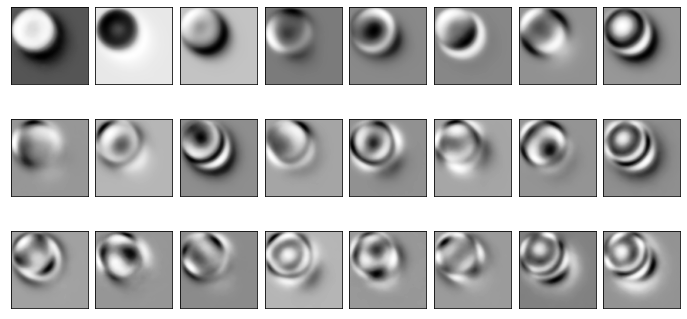

In [14]:
fig, axes = plt.subplots(3, 8, figsize=(12, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca_full_variance.components_[i].reshape(100, 100), cmap='Greys_r')

* these visual results of the pca seem very promising: looking at the first two principal components the first shows a light color within the sample area indicating an uninfected sample and the second a dark color indicating a parsitized sample

In [15]:
X_reduced = pca_full_variance.transform(X_full)
X_reduced.shape

(27558, 96)

## Support Vector Machine

### Rationale for using this model class

I decided to use SVM for the following reasons:
* the algorithm is especially well suited for dichotomous classification   
* it is robust against overfitting even with a high number of features   
* with the rbf kernel it can cover non-linearity very well

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

### Prepare data

create target variable

In [17]:
y_positive = np.ones(X_positive_bright.shape[0])
y_negative = np.zeros(X_negative_bright.shape[0])
y = np.hstack((y_positive, y_negative))

test and training dataset

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, stratify=y, train_size=0.5)

### Training and optimization of the model

Gridsearch on a 10x10 paramgrid for C and gamma resulted in optimal values of 70782 for C and 0.000977 for gamma.

In [ ]:
# Modified SVC model with probability=True
from sklearn.svm import SVC
model_svc = SVC(C=70782, gamma=0.000977, probability=True)
model_svc.fit(X_train, y_train)

In [ ]:
import joblib
from IPython.display import FileLink, display

# Define your model and PCA saving function
def save_models():
    joblib.dump(model_svc, '/kaggle/working/malaria_svc_model.joblib')
    joblib.dump(pca_full_variance, '/kaggle/working/malaria_pca.joblib')

# Call the function to save the models
save_models()

# Display download links for each saved model
display(FileLink('/kaggle/working/malaria_svc_model.joblib'))
display(FileLink('/kaggle/working/malaria_pca.joblib'))

### Evaluation

In [ ]:
pred = model_svc.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
plot_confusion_matrix(model_svc, X_test, y_test,
                     cmap=plt.cm.Blues,
                                 normalize='true')
plt.show();

Second Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import os
from skimage import io, exposure ,color #Convert the image to grayscale using `color.rgb2gray`
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder
import cv2 # : Imports OpenCV for image processing tasks.
import seaborn as sns  # Import seaborn for better visualization
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
#pipeline
alpha_value = 0.01  # Adjust this value as needed
model_pipeline = make_pipeline(
    StandardScaler(), 
    SGDClassifier(loss='log_loss', alpha=alpha_value, max_iter=1000, random_state=42)
)

In [ ]:
# Fit the model on the training data using the pipeline (with scaling)
model_pipeline.fit(X_train, y_train)

In [ ]:
# Import joblib
from joblib import dump, load

# Save the trained pipeline model
dump(model_pipeline, 'model_pipeline.joblib')

In [ ]:
# Calculate predicted probabilities for each class separately
y_prob_hog = model_pipeline.predict_proba(X_test)

In [ ]:
# Make predictions on the test set
y_pred_hog = model_pipeline.predict(X_test)

In [ ]:
accuracy_hog = accuracy_score(y_test, y_pred_hog)
print(f"Accuracy for HOG: {accuracy_hog}")

In [ ]:
print("Classification Report for HOG:")
print(classification_report(y_test, y_pred_hog, target_names=label_encoder.classes_))

In [ ]:
plot_roc_curve_multi_class(y_test, y_prob_hog, classes=label_encoder.classes_)

In [ ]:
plot_confusion_matrix(model_svc, X_test, y_test,
                     cmap=plt.cm.Blues,
                                 normalize='true')
plt.show();

In [ ]:
plot_loss_curve_on_training_and_testing_data(model_pipeline.named_steps['sgdclassifier'], X_train, y_train, X_test, y_test)